# Utilizar todos nuestros recursos de la semana anterior, enfocados en la data de las super novas

Primero, importamos las librerias necesarias

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib as mpl
from getdist import plots, MCSamples
import getdist
import cosmolopy.distance as cd

## Funciones y variables iniciales 

#### Léemos los datos

In [2]:
data = pd.read_csv("../datos/dataSupernova/jla_lcparams.txt", sep=" ").sort_values(by="zcmb")
data

,#name,zcmb,zhel,dz,mb,dmb,x1,dx1,color,dcolor,...,d3rdvar,tmax,dtmax,cov_m_s,cov_m_c,cov_s_c,set,ra,dec,biascor
648,sn1999ac,0.010060,0.009500,0,14.148421,0.174566,0.202688,0.068440,0.048593,0.025981,...,0.128500,51250.610935,0.078970,0.000244,0.000652,-0.000154,3,241.812542,7.972333,-0.008427
691,sn2004s,0.010291,0.009370,0,14.157498,0.173593,-0.117402,0.082511,0.022258,0.024846,...,0.280891,53040.308109,0.290845,-0.000483,0.000665,-0.000348,3,101.431250,-31.231250,-0.008430
641,sn1997do,0.010550,0.010120,0,14.449314,0.173090,0.791332,0.187870,0.118415,0.030547,...,0.280891,50766.597803,0.115604,0.003521,0.000989,0.001322,3,111.677083,47.093333,-0.008434
673,sn2002dp,0.010888,0.011638,0,14.557203,0.169021,-0.316464,0.184325,0.054095,0.023005,...,0.363500,52451.216137,0.133147,0.001596,0.000487,0.001020,3,352.125430,22.427240,-0.008440
713,sn2006bh,0.011184,0.010900,0,14.342973,0.166533,-1.648794,0.032216,-0.083155,0.019407,...,0.352000,53833.523740,0.039787,-0.000039,0.000286,-0.000115,3,340.067078,-66.485085,-0.008446
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
225,06D3en,1.060801,1.060000,0,24.707870,0.132013,-0.952679,0.412773,-0.158207,0.061030,...,0.935000,53881.407872,0.949506,0.010444,-0.003050,0.004456,1,215.305567,52.456079,-0.036389
242,Gabi,1.120850,1.120000,0,25.147113,0.121686,0.620453,0.307485,-0.075491,0.053200,...,0.296000,53488.738514,0.524573,0.004032,0.000388,0.005988,4,189.057630,62.202100,0.000000
243,Lancaster,1.230892,1.230000,0,26.046776,0.128558,-0.077374,0.690464,0.087011,0.048271,...,0.194500,53431.841687,1.597837,0.003542,0.000211,0.008241,4,189.236330,62.214814,0.000000
614,Torngasek,1.265901,1.265000,0,25.735598,0.128614,0.286816,0.559546,0.021062,0.047718,...,0.391000,52693.622067,1.790259,-0.003817,-0.000169,0.003064,4,189.331960,62.310417,0.000000


## Funciones de caclulos

#### Error de nuestro modelo

In [3]:
# Codigo sacado exactamente igual del repositorio de Missa, no supe qué es la verdad jaja
matrix0a = pd.read_csv("../datos/dataSupernova/jla_v0a_covmatrix.dat", sep=" ").to_numpy().reshape(740, 740)
matrix0b = pd.read_csv("../datos/dataSupernova/jla_v0b_covmatrix.dat", sep=" ").to_numpy().reshape(740, 740)
matrixv0 = pd.read_csv("../datos/dataSupernova/jla_v0_covmatrix.dat", sep=" ").to_numpy().reshape(740, 740)
matrixvab = pd.read_csv("../datos/dataSupernova/jla_vab_covmatrix.dat", sep=" ").to_numpy().reshape(740, 740)
matrixva = pd.read_csv("../datos/dataSupernova/jla_va_covmatrix.dat", sep=" ").to_numpy().reshape(740, 740)
matrixvb = pd.read_csv("../datos/dataSupernova/jla_vb_covmatrix.dat", sep=" ").to_numpy().reshape(740, 740)

matrix = matrix0a + matrix0b + matrixv0 + matrixvab + matrixva + matrixvb
matrix_inv = np.linalg.inv(matrix) 

error = np.zeros(740)

for i in range(740):
    error[i] = np.sqrt(matrix[i][i])

#### Prior para nuestras supernovas

In [4]:
def logPrior(parametros):
    '''
    DESCRIPTION: Esta función nos regresa lo que sabemos de nuestros parámetros a priori
    IN = {
        parametros: Los parámetros que estamos analizando
    }
    OUT: El prior
    '''
    inf = [-6, -3, -25, -6]
    sup = [6, 9, -15, 6]
    pointPrior = np.zeros(4)
    
    for i in range(4):
        if inf[i]<parametros[i]<sup[i]:
            pointPrior[i] = -1*np.log(sup[i]-inf[i])
            
    return sum(pointPrior)

In [5]:
# Se define el método montecarlo
def montecarlo(x, y, sigmaX, sigmaY, model, initPoints, pasosTotales, logLikelihood, logPrior=0):
    '''
    Descripción: Usa valores, en principio, aleatorios para determinar los parámetros que mejor se ajustan
    a ciertos datos, dado un modelo específico, a partir de un punto (o varios puntos) inicial. 
    El procedimiento se detalla más adelante en los comentarios del código.
    IN = {
        x: Variable dependiente de estos datos
        y: Variable independiente de estos datos
        model: El modelo a comparar
        initPoints: Una lista de n puntos iniciales (Uno por por cada cadena que se desee), estos puntos iniciales representan
        los parámetros que quiero averiguar.
        pasosTotales: Los pasos máximos que quieras que se "caminen" tus cadenas
        sigmaX: Desviación estándar de la variable x
        sigmaY: Desviación estándar de la variable y
    }
    '''
    # Se asigna una semilla específica para hacer comparaciones con otros repositorios, pero se puede quitar sin problemas
    np.random.seed(500)
    # Se declaran la cadena llamada "Cadena de Markov" y se define la "Matriz de Markov" para albergar varias cadenas
    # Específicamente serán n cadenas, donde n es la cantidad de puntos iniciales que tenemos
    markovMatrix = []
    markovChain = []
    # Se define una lista para la tasa de aceptación 
    aceptado = []
    # Este ciclo creará las n cadenas (recuerde, una por cada punto)
    for index, point in enumerate(initPoints):
        # Se crea el punto inicial, renombrado como p_old, luego será reemplazado por un p_new
        p_old = point
        # Se crea el logaritmo del likelihood relacionado con el punto inicial
        L_old = logLikelihood(x, y, model, sigmaY, p_old)
        # Realmente lo que nos importa es el Posterior, lo calculamos haciendo lo siguiente:
        logPosterior_old = L_old + logPrior(p_old)
        # Se agrega a la cadena de Markov
        markovChain = [[p_old, logPosterior_old]]
        # los elementos de la cadena aceptado siempre inician en 0
        aceptado.append(0)
        
        # Queremos que el algoritom se ejecute "PasosTotales" número de veces.
        for paso in range(pasosTotales):
            # Se define un nuevo punto de parámetros en una vecindad cercana al punto anterior, escogido de manera aleatoria
            p_new = [punto + sigmaX[index]*np.random.randn() for index, punto in enumerate(p_old)]
            # Se crea el logaritmo del likelihood asociado a este nuevo punto.
            L_new = logLikelihood(x, y, model, sigmaY, p_new)
            # Se crea, de nuevo, el posterior
            logPosterior_new = L_new + logPrior(p_new)
        
            # Condiciones para que el nuevo punto sea acepado
            # Que el nuevo likelihood, sea mayor que el anterior o
            # Que la razón entre nuestros likelihoods sea mayor a un número aleatorio.
            if (logPosterior_new>logPosterior_old or logPosterior_new-logPosterior_old>np.random.randn()):
                # Si es así, agregamos nuestro punto a la cadena de Markov y sustituimos nuestros viejos puntos y 
                # likelihood con los nuevos para repetir el proceso después
                markovChain.append([p_new, logPosterior_new])
                p_old = p_new
                logPosterior_old = logPosterior_new
                # Agregamos uno a la suma para nuestra tasa de aceptación
                aceptado[index] += 1
            else:
                # Si no se cumple lo anterior, aún así guardamos el punto creado, sin embargo ya no sustituimos los puntos
                # anteriores con los nuevos, así se repetirá el ciclo pero con los puntos anteriores
                markovChain.append([p_new, logPosterior_new])
        
        # Cada cadena de markov se guarda en nuestra "Matriz de Markov"
        markovMatrix.append(markovChain)
    # Calculamos la tasa de aceptación
    aceptados = tasaAceptacion(aceptado, pasosTotales)        
    # Regresamos nuestra Matriz de Markov y nuestra tasa de aceptación
    return [markovMatrix, aceptados]
    

In [6]:
def logLikelihood(x, y, model, sigma, theta):
    '''
    Descripcion: Esta función mida lo bien que un modelo estadístico se adecúa a unos datos
    para los valores de parámetros desconocidos.
    In = {
        x: Variable independiente a analizar
        y: Variable dependiente a analizar
        model: El modelo con el cual lo estamos comparando
        theta: Los parámetros de este modelo
    }
    OUT: El likelihood
    '''
    # Variable suma empezada en 0
    suma = 0
    # Construimos la suma correspondiente a la fórmula del likelihood proporcionada en las notas de la maestra.
    for i in range(len(x)):
        suma += (y[i] - model(x[i], theta))**2 / sigma[i]**2
    
    return -(0.5) * suma

In [7]:
# Tasa de aceptación
def tasaAceptacion(lista, pasosTotales):
    '''
    Descripción: Función que calcula la razón entre la cantidad de pasos aceptados por el método montecarlo
    y la cantidad de pasos totales
    IN = {
        lista: La lista de la cantidad de pasos aceptados de las n cadenas
        pasos: La cantidad de pasos totales del método
    }
    OUT: Una lista de n elementos con la tasa de aceptación para las n cadenas
    '''
    
    listTasa = []
    for index, accepted in enumerate(lista):
        listTasa.append(accepted/pasosTotales)
    return listTasa

In [8]:
def gelmanRubin(cadenas):
    '''
    Descripción: Esta función determina si las cadenas que obtuvimos convergen o no convergen, si el resultado de una o más
    cadenas es mayor a 1.1 entonces dicha cadena no converge
    IN ={
        cadenas: Las cadenas de Markov que deseamos analizar
    }
    OUT: Una lista con el resultado del diagnóstico por cada cadena
    NOTA: Esta función fue deducida de las notas de la maestra
    '''
    # Definimos algunas variables que utilizaremos luego
    # Él número de cadeas
    numeroCadenas = len(cadenas)
    # Cuántos pasos tiene cada cadena
    pasosTotal = len(cadenas[0])
    # Número de parámetros
    numeroParametros = len(cadenas[0][0][0])
    
    # Extraemos cada punto de las cadenas y las separamos en una lista de listas por cadena
    puntos = [[] for x in range(numeroCadenas)]
    [puntos[index].append(paso[0]) for index, cadena in enumerate(cadenas) for paso in cadena]
    puntos = np.array(puntos) # Nota: convertimos a un arreglo de numpy por un paso más adelante
    #print(puntos[0][0][1])
    
    for parametro in range(numeroParametros):
        # Definimos si que es una lista de desviaciones estándar de las cadenas (Empiezan en 0)
        si = np.zeros(numeroCadenas)
        # Definimos una lista para las medias de cada cadena y la llenamos con el valor del parámetro
        media = [[] for x in range(numeroCadenas)]
        [media[index].append(punto[parametro]) for index, cadena in enumerate(puntos) for punto in cadena]
        # Sacamos las medias de cada una de las cadenas para el parametro y las guardamos en una variable llamada mediaFinal
        mediaFinal = [np.average(media[index]) for index, aux in enumerate(media)] 
        #print(mediaFinal)
        
        # Con este pedazo de código, calculamos la varianza para cada una de las cadenas
        for cadena in range(numeroCadenas):
            for paso in range(pasosTotal):
                si[cadena] += (puntos[cadena][paso][parametro]-mediaFinal[cadena])**2
        si /= (pasosTotal - 1)
        
        # Definimos s^2 que usaremos después
        s = sum(si)/numeroCadenas
        
        # Definimos miu como la media de todas las cadenas sobre este parámetro
        miu = np.average(mediaFinal)
        
        # Definimos una variable Bn
        Bn = (sum((mediaFinal - miu)**2))/numeroCadenas
        
        # Creamos la variable sigma
        sigma = ((pasosTotal-1)*s)/pasosTotal + Bn
        
        # Y finalmente calculamos R
        R = (sigma/s)**(1/2)
        print(f'El diagnóstico resultante del parámetro {parametro} es: {R:.6}')

In [27]:
def calcMu(data, omega):
    '''
    Descripción: Función que regresa como valor, mu
    '''
    #print(data[index] - (omega[2]- data["x1"]*omega[0] + omega[1]*color))
    return data["mb"] - (omega[2]- data["x1"]*omega[0] + omega[1]*data["color"])

In [9]:
def muPuntoAPunto(parametro, omega):
    mb = parametro[4]
    x1 = parametro[6]
    color = parametro[8]

    #Regresamos el valor de mu en ese punto
    return mb - (omega[2] - omega[0]*x1 + omega[1]*color)

## Funciones de visualización

#### Visualizar las cadenas de Markov de dos parámetros

In [10]:
# Definimos función para ver las cadenas de markov
def verCadenasMarkov(cadenas, realPoint=False, corte=0, params=[0,1]):
    '''
    Descripcion: Una función que nos ayuda a visualizar las cadenas generadas
    IN = {
        cadenas: Las cadenas generadas con el método Monte Carlo
        realPoint: El punto real si es que lo conocemos
        corte: El burning si es que existe
    }
    Out: Gráfica de nuestras cadenas
    '''
    # Se define el tamaño de nuestra gráfica en estos objetos
    fig, ax0 = plt.subplots(figsize=(7, 7))
    # Extraemos la información de cada una de nuestras cadenas para ser graficados
    for index, cadenita in enumerate(cadenas):
        x = [punto[params[0]] for punto, likelihood in cadenita[corte:]]
        y = [punto[params[1]] for punto, likelihood in cadenita[corte:]]
        likelihoods = [likelihood for punto, likelihood in cadenita]
        # Se grafica punto por punto
        chain_plot = ax0.scatter(x, y, marker = '.', alpha = 0.5, label = f"Cadena {index}")
        
    #Si conocemos el punto real (Es decir, los parámetros reales)
    if(realPoint):
        # Se grafica el punto real (Porque en este caso lo conocemos)
        plt.plot(realPoint[params[0]], realPoint[params[1]], marker = 's', label = 'Valor real', c = 'Black')
        
    # Se agregan las leyendas, los nombres de los ejes y la cuadrícula
    plt.legend()
    ax0.set_xlabel(f'Parametro {params[0]}')
    ax0.set_ylabel(f'Parametro {params[1]}') 
    ax0.grid()
    plt.show()

#### Visualizar los n parámetros en el número de pasos de la cadena

In [11]:
# Definimos la función para graficar el número de pasos vs los parámetros
def graphParameters(cadena, labels=[], corte=0):
    '''
        Descripción: Visualizar el valor que tiene cada parámetro por cada paso de la cadena dada.
        IN = {
            cadena: La cadena en donde se analizarán los pasos
            corte: Se revisa si existe algún "burning" o corte para hacer "Zoom"
            labels: Nombre de los ejes
        }
    '''  
    # Definirimos cosas que usaremos después, los nombres de las variables expresan claramente lo que significan
    numeroParametros = len(cadena[0][0])
    listaParametros = [[] for parametro in range(numeroParametros)]
    numeroPasos = len(cadena[corte:])
    graficaNumeroPasos = list(range(corte, len(cadena)))
    
    # Separamos los parámetros en listas, para que no estén "revueltos"
    [listaParametros[index].append(parametro) for parametros in cadena[corte:] for index, parametro in enumerate(parametros[0])]
    
    # Creamos el objeto figura y nuestros axs, además, le quitamos heigh space para que estén juntas y sea más claro.
    fig, ax = plt.subplots(numeroParametros, 1, sharex=True, figsize = (10, 7))
    fig.subplots_adjust(hspace=0)
    
    if(labels == []):
        labels = [numero for numero in range(numeroParametros)]
    
    # Nuestro primera gráfica será el que "carge" con el títitulo
    ax[0].set_title('Valor de los parámetros en cada paso')
    # Tenemos que hacer un for por cada uno de los parámetros que hay
    for index, parametro in enumerate(listaParametros):
        # Sacamos su media para comparar lo que estamos haciendo y si tiene algún tipo de distribución
        media = np.percentile(np.array(parametro), 50)
        # Graficamos cada una de los parámetros y su media
        ax[index].plot(graficaNumeroPasos, parametro)
        ax[index].plot(graficaNumeroPasos, [media for aux in graficaNumeroPasos])
        # Le ponemos nombre y cuadrícula a las gráficas
        ax[index].set_ylabel(labels[index])
        ax[index].grid()
    # Y por útlimo, ponemos el eje y  
    ax[numeroParametros-1].set_xlabel('Número de pasos')

#### Gráficas triangulares con getdist

In [12]:
def trianglePlot(cadenas, corte=0, labels=[]):
    '''
    Descricpión: Esta función nos permite visualizar de una manera más atractiva (y más clara) a los parámetros y sus pasos
    en la cadena de markov
    IN = {
        cadena: La cadena de Markov la cual estaremas graficando
        corte: El burning para tener algo más claro
        labels: Los nombres de los parámetros
    }
    Out: Una bonita gráfica
    '''
    # Definimos una variable auxiliar
    numeroParametros = len(cadenas[0][0][0])
    # Si labels no está definido, lo predefinimos como "parametro 1, parametro 2,..."
    if(labels==[]):
        labels = [f"Parámetro{index}" for index in range(numeroParametros)]
    # Definimos el objeto central de getdist
    g = plots.get_subplot_plotter(subplot_size=3)
    # Extraemos todos los puntos        
    data = [paso[0] for cadena in cadenas for paso in cadena[corte:]]
    # Algunas funciones de getdist para graficar
    samples = MCSamples(samples=np.array(data[corte:]), labels=labels, names=labels)
    g.triangle_plot(samples, filled=True, contour_colors=["#00bcd4"], title_limit=1)

#### Histograma en 2D

In [44]:
def plotHist2d(cadenas, parametros, bins=200, labels=[], corte=0):
    '''
    DESCRIPTION: Genera un histograma en 2D para dos parámetros únicamente
    IN = {
        cadena: La cadena de donde sacaremos los parámetros
        parametros: Una lista de los dos parámetros que queremos sacar
        bins: Las particiones del histograma 100 es el recomendado
        lables: El nombre de los parámetros
        corte: El burning
    }
    OUT: Un bonito histograma 2D
    '''     
    if(labels==[]):
        labels=[x for x in parametros]
    # Extraemos cada punto de las cadenas
    puntos = [paso[0] for cadena in cadenas for paso in cadena[corte:]]
    
    # Extraemos cada parámetro que queremos
    x = [punto[parametros[0]] for punto in puntos]
    y = [punto[parametros[1]] for punto in puntos]
    
    # Graficamos
    plt.hist2d(x, y, bins = bins, cmap = 'RdPu_r')
    # Añadimos los nombres de los labels
    plt.ylabel(labels[1])
    plt.xlabel(labels[0])
    plt.colorbar(label = 'Frecuencia')
    plt.show()

## Ejecución del código con los datos de la supernovas

In [46]:
np.random.seed(200)

#Parametros y sus desviaciones
omegaReal = [0.1, 3, -19, 0.5]
desviacionReal = [0.1, 0.1, 0.1, 0.1]

#Construimos la recta:
x = np.array(data)
y = np.array(calcMu(data, omegaReal))
numeroCadenas = 8
aux = 5

# Puntos iniciales al rededor de los parámetros aproximados de arriba, puntos aleatorios
omegaIniciales = [[aux*np.random.randn() + omegaReal[parametro] for parametro in range(len(omegaReal))] for cadena in range(numeroCadenas)]

# Aplicamos el método montecarlo
montecarloResult = montecarlo(x=x, y=y, sigmaX=desviacionReal, sigmaY=error, model=muPuntoAPunto,
                        initPoints=omegaIniciales, pasosTotales=10000, logLikelihood = logLikelihood, logPrior = logPrior)
# Extraemos y separamos nuestros resultados
cadenas=montecarloResult[0]
tasaAceptada=montecarloResult[1]

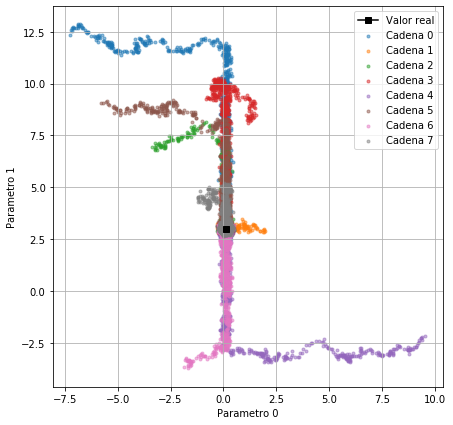

In [48]:
verCadenasMarkov(cadenas=cadenas, realPoint=omegaReal, params=[0,1])

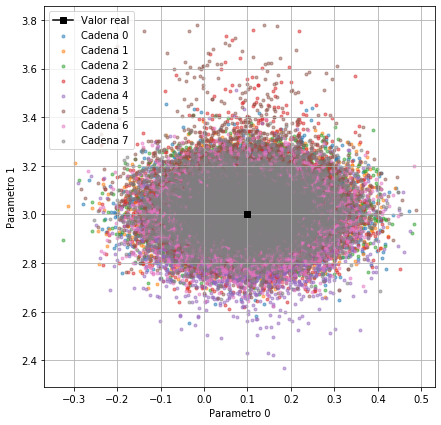

In [49]:
# Hagamos un pequeño zoom
verCadenasMarkov(cadenas=cadenas, realPoint=omegaReal, params=[0,1], corte=1000)

In [50]:
# Conocer la tasa de aceptación
for index, accepted in enumerate(tasaAceptada):
    print(f"La tasa de rechazo de la cadena {index} es: {accepted}")

La tasa de rechazo de la cadena 0 es: 0.021
La tasa de rechazo de la cadena 1 es: 0.0046
La tasa de rechazo de la cadena 2 es: 0.0091
La tasa de rechazo de la cadena 3 es: 0.0218
La tasa de rechazo de la cadena 4 es: 0.0208
La tasa de rechazo de la cadena 5 es: 0.0172
La tasa de rechazo de la cadena 6 es: 0.0103
La tasa de rechazo de la cadena 7 es: 0.008


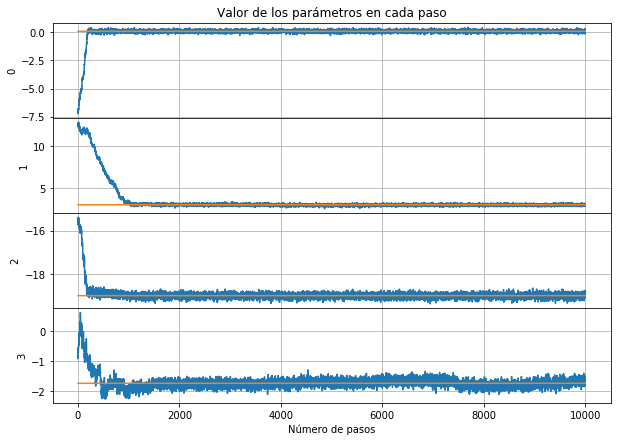

In [51]:
graphParameters(cadena=cadenas[0])

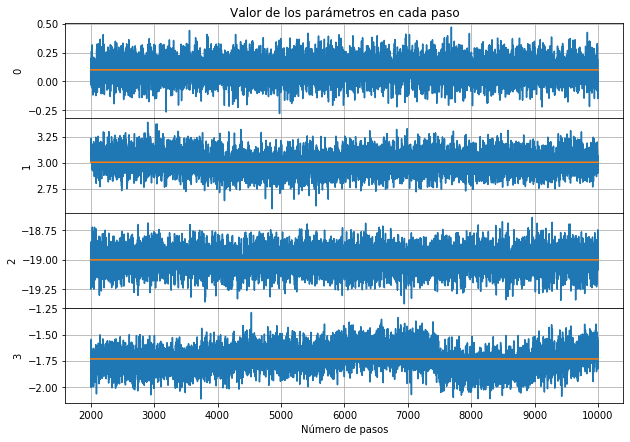

In [52]:
# Hagamos un burning
graphParameters(cadena=cadenas[0], corte=2000)

Removed no burn in


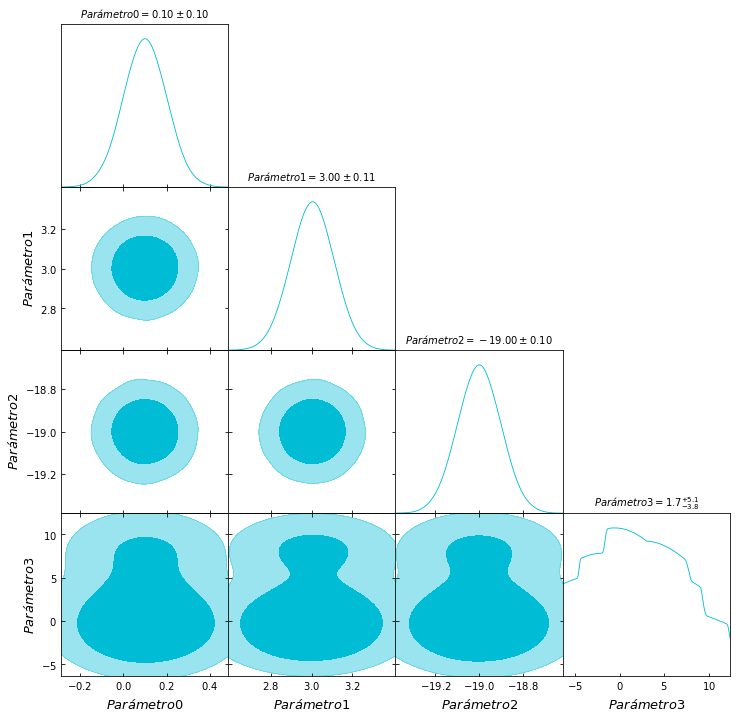

In [53]:
trianglePlot(cadenas=cadenas, corte=2000)

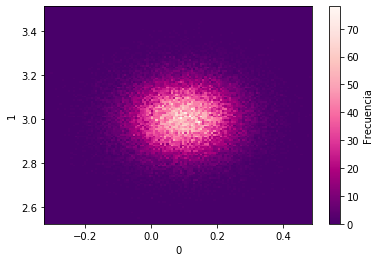

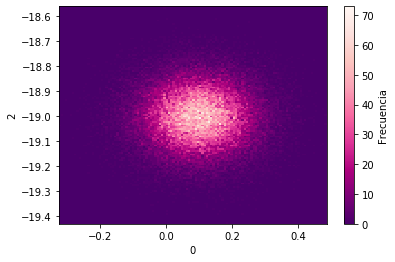

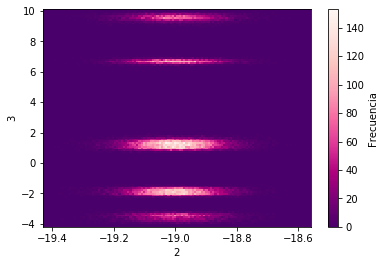

In [54]:
plotHist2d(cadenas=cadenas, parametros=[0,1], bins=120, corte=1500)
plotHist2d(cadenas=cadenas, parametros=[0,2], bins=120, corte=1500)
plotHist2d(cadenas=cadenas, parametros=[2,3], bins=120, corte=1500)

In [55]:
gelmanRubin(cadenas)

El diagnóstico resultante del parámetro 0 es: 1.0078
El diagnóstico resultante del parámetro 1 es: 1.03333
El diagnóstico resultante del parámetro 2 es: 1.0082
El diagnóstico resultante del parámetro 3 es: 18.2276
